In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics.regression import mean_squared_error
%matplotlib inline

In [86]:
class GaussianDensity(object):
    def __init__(self, h=1, model=None):
        self.h = h
        self.model = model or LinearRegression()
        self.X = None
        
    def fit(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        self.X = X
        G = sp.stats.norm.pdf(euclidean_distances(X, X)/self.h)
        self.model.fit(G.T.dot(G)+np.eye(G.shape[1])*1e-9, G.T.dot(y))
        return self
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        G = sp.stats.norm.pdf(euclidean_distances(X, self.X)/self.h)
        return self.model.predict(G)
    
    def score(self, X, y):
        return -mean_squared_error(self.predict(X), y)
    
    def get_params(self, deep=True):
        return {"h": self.h}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class GaussianDensityMultiH(object):
    def __init__(self, hs=[1], kernel=rbf_kernel, model=None):
        self.hs = hs
        self.kernel_ = kernel
        self.model = model or LinearRegression()
        self.X = None
        
    def fit(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        self.X = X
        G = np.hstack([sp.stats.norm.pdf(euclidean_distances(X, self.X)/self.h) for h in self.hs])
        self.model.fit(G.T.dot(G), G.T.dot(y))
        return self
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        G = np.hstack([sp.stats.norm.pdf(euclidean_distances(X, self.X)/self.h) for h in self.hs])
        return self.model.predict(G)
    
    def score(self, X, y):
        return -mean_squared_error(self.predict(X), y)
    
    def get_params(self, deep=True):
        return {"h": self.h}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [166]:
from sklearn.kernel_ridge import KernelRidge

fl = pd.read_csv('./data/Locations.txt', sep=' ')
fm = pd.read_csv('./data/Oregon_Met_Data.txt', sep=' ')

def mean_temperature(sid, fm=fm):
    possible = np.logical_and(fm.SID.as_matrix() == sid, fm.Tmin_deg_C.as_matrix() < 999)
    X1 = fm.Time.as_matrix()[possible]
    X1 = X1.reshape((X1.size,1))
    Y1 = fm.Tmin_deg_C.as_matrix()[possible]
    days = np.arange(1, fm.Time.max()+1)
    days = days.reshape((days.size, 1))
    return np.mean(KernelRidge(kernel='rbf', gamma=1).fit(X1, Y1).predict(days))

def mean_temperature2(sid, fm=fm):
    possible = np.logical_and(fm.SID.as_matrix() == sid, fm.Tmin_deg_C.as_matrix() < 999)
    Y = fm.Tmin_deg_C.as_matrix()[possible]
    return np.mean(Y)
    
# the position of the all the 
positions = np.vstack([fl.East_UTM.as_matrix(), fl.North_UTM.as_matrix()]).T
temps = np.array([mean_temperature2(i) for i in range(fm.SID.min(), fm.SID.max()+1)])
long, lat = np.meshgrid(
    np.linspace(fl.East_UTM.min()-1, fl.East_UTM.max()+1, 100),
    np.linspace(fl.North_UTM.min()-1, fl.North_UTM.max()+1, 100))
    
grid = np.vstack([long.ravel(), lat.ravel()]).T

the mean distance between two point is 126738.925065


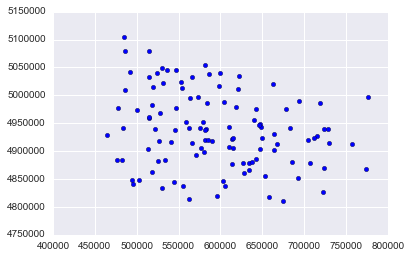

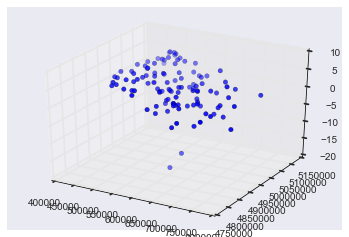

In [163]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(1)
plt.scatter(x=positions[:,0], y=positions[:,1])
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], temps)
print("the mean distance between two point is %f"%(np.mean(euclidean_distances(positions, positions))))

<a list of 12 text.Text objects>

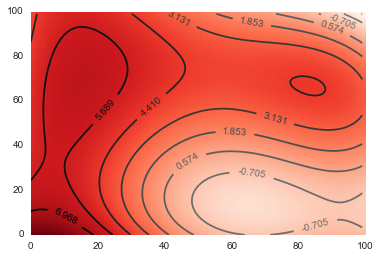

In [179]:
from sklearn.grid_search import GridSearchCV
linear = GaussianDensity()
gs = GridSearchCV(linear, {'h': 126738*1.2**np.arange(-5, 5, 0.3)}, refit=True);
gs.fit(positions, temps)
temresult = gs.predict(grid).reshape((100, 100))
plt.pcolor(temresult,cmap=plt.cm.Reds)
cs = plt.contour(temresult, levels=np.linspace(np.min(temps), np.max(temps), 20)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

(202176.65490871257, 2.9838267639008187)


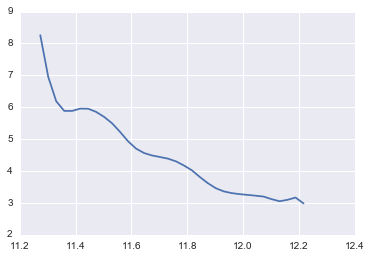

In [176]:
from sklearn.cross_validation import train_test_split
trainx, testx, trainy, testy = train_test_split(positions, temps)
hs = 126738*1.1**np.arange(-5, 5, 0.3)
e = np.zeros(hs.shape)
for i,h in enumerate(hs):
    e[i] = mean_squared_error(GaussianDensity(h=h).fit(trainx, trainy).predict(testx), testy)

print((hs[np.argmin(e)], np.min(e)))
plt.plot(np.log(hs), e)
    

lowest EMS = 8.728745
chosen h = 293184.212975


<a list of 5 text.Text objects>

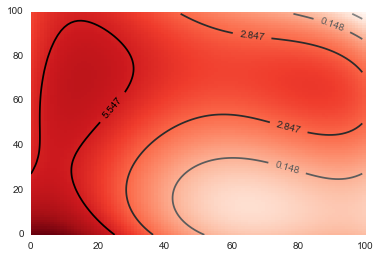

In [180]:
print("lowest EMS = %f"%(-gs.best_score_))
print("chosen h = %f"%(gs.best_params_['h']))
temresult = gs.predict(grid).reshape((100, 100))
plt.pcolor(temresult,cmap=plt.cm.Reds)
cs = plt.contour(temresult, levels=np.linspace(np.min(temps), np.max(temps), 10)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

In [183]:
hs = 126738*1.1**np.arange(-2, 2, 0.3)
lasso = LassoCV(max_iter=15000, alphas=np.logspace(-4, 4, 1))
gs = GaussianDensityMultiH(model=lasso, hs=hs)
gs.fit(positions, temps)

best EMS = -0.000113
alpha used = 0.000100
number of parameter used = 803.000000
number of parameter unused = 765.000000


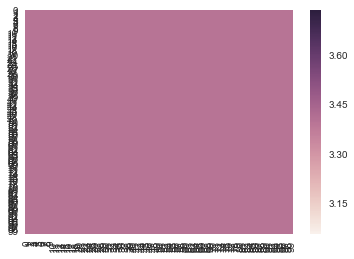

In [184]:
print("best EMS = %f"%(gs.score(positions, temps)))
print("alpha used = %f"%(lasso.alpha_))
print("number of parameter used = %f"%(np.sum(lasso.coef_!=0)))
print("number of parameter unused = %f"%(np.sum(lasso.coef_==0)))
temresult = gs.predict(grid).reshape((100, 100))
sns.heatmap(temresult)
# cs = plt.contour(temresult, levels=np.linspace(np.min(temresult), np.max(temresult), 5)[1:-1])
# plt.clabel(cs, inline=1, fontsize=10)

In [ ]:
hs = 2.0**np.arange(-20, 20)
elastic = ElasticNetCV(max_iter=15000, alphas=np.logspace(-4, -.5, 30), l1_ratio=np.array(np.linspaceepace(0, 1, 4)))
gs = GaussianDensityMultiH(model=lasso, hs=hs)
gs.fit(positions, temps)

In [ ]:
print("best EMS = %f"%(gs.score(positions, temps)))
print("number of parameter used = %f"%(np.sum(lasso.coef_!=0)))
print("number of parameter unused = %f"%(np.sum(lasso.coef_==0)))
temresult = gs.predict(grid).reshape((100, 100))
sns.heatmap(temresult)
cs = plt.contour(temresult, levels=np.linspace(np.min(temresult), np.max(temresult), 10)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

In [158]:
positions

array([[-121.330833,   44.0475  ],
       [-121.146667,   44.68    ],
       [-120.948333,   44.248333],
       [-120.733333,   44.916667],
       [-120.216667,   43.95    ],
       [-122.816667,   45.45    ],
       [-122.033333,   44.3     ],
       [-121.283333,   44.066667],
       [-121.216667,   44.116667],
       [-121.95    ,   45.633333],
       [-120.6     ,   43.8     ],
       [-122.483333,   44.4     ],
       [-123.2     ,   46.1     ],
       [-123.2     ,   44.633333],
       [-123.45    ,   44.516667],
       [-123.066667,   43.783333],
       [-123.05    ,   43.716667],
       [-123.283333,   44.95    ],
       [-122.25    ,   44.716667],
       [-122.966667,   43.783333],
       [-122.316667,   45.266667],
       [-123.216667,   44.116667],
       [-123.3     ,   44.116667],
       [-123.1     ,   45.533333],
       [-120.216667,   45.      ],
       [-122.666667,   44.416667],
       [-121.75    ,   45.3     ],
       [-120.933333,   44.516667],
       [-122.15    ,

In [159]:
fl

,SID,Name,Lat_DMS,Long_DMS,Latitude_DD,Longitude_DD,East_UTM,North_UTM,Elevation_m,Slope_deg,Aspect_deg,Network,LongName,Records_Begin
0,1,BEWO,44:02:51,121:19:13,44.047500,-121.330833,633717.80,4878502.97,1114,0.00,0.000,Agrimet,Bend,2003
1,2,MRSO,44:40:48,121:08:55,44.680000,-121.146667,646882.12,4949074.13,742,2.62,270.000,Agrimet,Madras,1984
2,3,POBO,44:14:54,120:56:59,44.248333,-120.948333,663803.89,4901502.12,975,0.00,0.000,Agrimet,Powell.Bute,1993
3,4,350197,44:55:00,120:44:00,44.916667,-120.733333,678906.98,4976192.55,861,9.75,77.200,COOP,Antelope.1.NW,1948
4,5,350501,43:57:00,120:13:00,43.950000,-120.216667,723341.94,4870085.96,1232,0.00,0.000,COOP,Barnes.STN,1961
5,6,350595,45:27:00,122:49:00,45.450000,-122.816667,514335.92,5032958.02,86,3.70,135.000,COOP,Beaverton.2.SSW,1972
6,7,350652,44:18:00,122:02:00,44.300000,-122.033333,577110.16,4905648.39,677,11.20,90.000,COOP,Belnap.Springs,1960
7,8,350694,44:04:00,121:17:00,44.066667,-121.283333,637478.72,4880710.02,1115,7.37,45.000,COOP,Bend,1948
8,9,350699,44:07:00,121:13:00,44.116667,-121.216667,642697.45,4886377.04,1023,2.62,0.000,COOP,Bend.7.NE,1990
9,10,350897,45:38:00,121:57:00,45.633333,-121.950000,581839.20,5053845.74,66,12.19,310.710,COOP,Bonnevill.Dam,1948


In [185]:
np.arange(-5, 5, 0.3)

array([-5. , -4.7, -4.4, -4.1, -3.8, -3.5, -3.2, -2.9, -2.6, -2.3, -2. ,
       -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ,  1.3,
        1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,  4.3,  4.6,
        4.9])